In [ ]:
# Jhose Immanuel Sembiring
# 1103202047
# TK44G4
# Modern CNN_VGG

#Library

In [ ]:
# Install required libraries
!pip install torch torchvision matplotlib

# Import required libraries
import torch
from torch import nn
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import matplotlib.pyplot as plt

#Mendefinisikan Fungsi Blok VGG



In [ ]:
# Define the VGG block
def vgg_block(num_convs, in_channels, out_channels):
    layers = []
    for _ in range(num_convs):
        layers.append(nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1))
        layers.append(nn.ReLU())
        in_channels = out_channels
    layers.append(nn.MaxPool2d(kernel_size=2, stride=2))
    return nn.Sequential(*layers)

# Define the VGG network
class VGG(nn.Module):
    def __init__(self, conv_arch, fc_features, fc_hidden_units=4096):
        super(VGG, self).__init__()
        self.conv_blocks = nn.Sequential()
        in_channels = 1
        for i, (num_convs, out_channels) in enumerate(conv_arch):
            self.conv_blocks.add_module(f'block{i+1}', vgg_block(num_convs, in_channels, out_channels))
            in_channels = out_channels

        self.fc = nn.Sequential(
            nn.Flatten(),
            nn.Linear(fc_features, fc_hidden_units),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(fc_hidden_units, fc_hidden_units),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(fc_hidden_units, 10)
        )

    def forward(self, x):
        x = self.conv_blocks(x)
        x = self.fc(x)
        return x

# Define the VGG-11 architecture
conv_arch = ((1, 64), (1, 128), (2, 256), (2, 512), (2, 512))
fc_features = 512 * 7 * 7
net = VGG(conv_arch, fc_features)


#Persiapan Dataset

In [ ]:
# Load FashionMNIST dataset
transform = transforms.Compose([transforms.Resize((224, 224)), transforms.ToTensor()])

train_dataset = datasets.FashionMNIST(root='../data', train=True, download=True, transform=transform)
test_dataset = datasets.FashionMNIST(root='../data', train=False, download=True, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True, num_workers=2)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False, num_workers=2)


#Melatih Model

Epoch [1/5], Loss: 0.2853
Epoch [2/5], Loss: 0.2463
Epoch [3/5], Loss: 0.2162
Epoch [4/5], Loss: 0.1986
Epoch [5/5], Loss: 0.1805


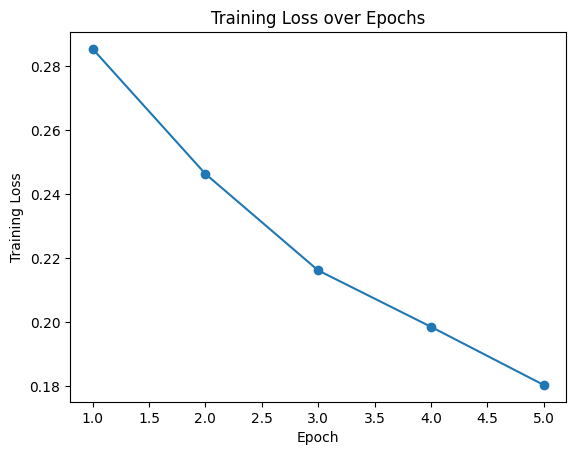

In [ ]:
# Define training parameters
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
net.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(net.parameters(), lr=0.001)

# Training loop
num_epochs = 5
train_losses = []

for epoch in range(num_epochs):
    net.train()
    running_loss = 0.0
    for i, (images, labels) in enumerate(train_loader):
        images, labels = images.to(device), labels.to(device)

        # Zero the parameter gradients
        optimizer.zero_grad()

        # Forward pass
        outputs = net(images)
        loss = criterion(outputs, labels)

        # Backward pass and optimization
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    epoch_loss = running_loss / len(train_loader)
    train_losses.append(epoch_loss)
    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {epoch_loss:.4f}')

# Plot training loss
plt.plot(range(1, num_epochs + 1), train_losses, marker='o')
plt.xlabel('Epoch')
plt.ylabel('Training Loss')
plt.title('Training Loss over Epochs')
plt.show()


#Evaluasi Model

In [ ]:
# Evaluation loop
net.eval()
correct = 0
total = 0
with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = net(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f'Test Accuracy: {100 * correct / total:.2f}%')
